# Lotka Volterra

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import matplotlib as mpl
import matplotlib.pyplot as plt
from loss_cal.tasks.lotka_volterra import LotkaVolterra
from loss_cal.costs import StepCost_weighted
from loss_cal.utils.plot import plot_step_loss
from loss_cal.utils.utils import load_data
from loss_cal.predictor import train, build_nn

plot_config_file = "loss_cal/utils/.matplotlibrc"

## Set Up

In [4]:
lv = LotkaVolterra(action_type="binary", num_actions=2)
lv.task_name

'lotka_volterra'

Prior and Simulator

In [5]:
prior = lv.get_prior()
simulator = lv.get_simulator()

In [6]:
print(lv.dim_data,              # dimensionality data, here: 20
      lv.dim_parameters,        # dimensionality parameters, here: 4
      lv.num_observations)      # number of different observations x_o available, here: 10

20 4 10


10 observations provided by the sbibm task

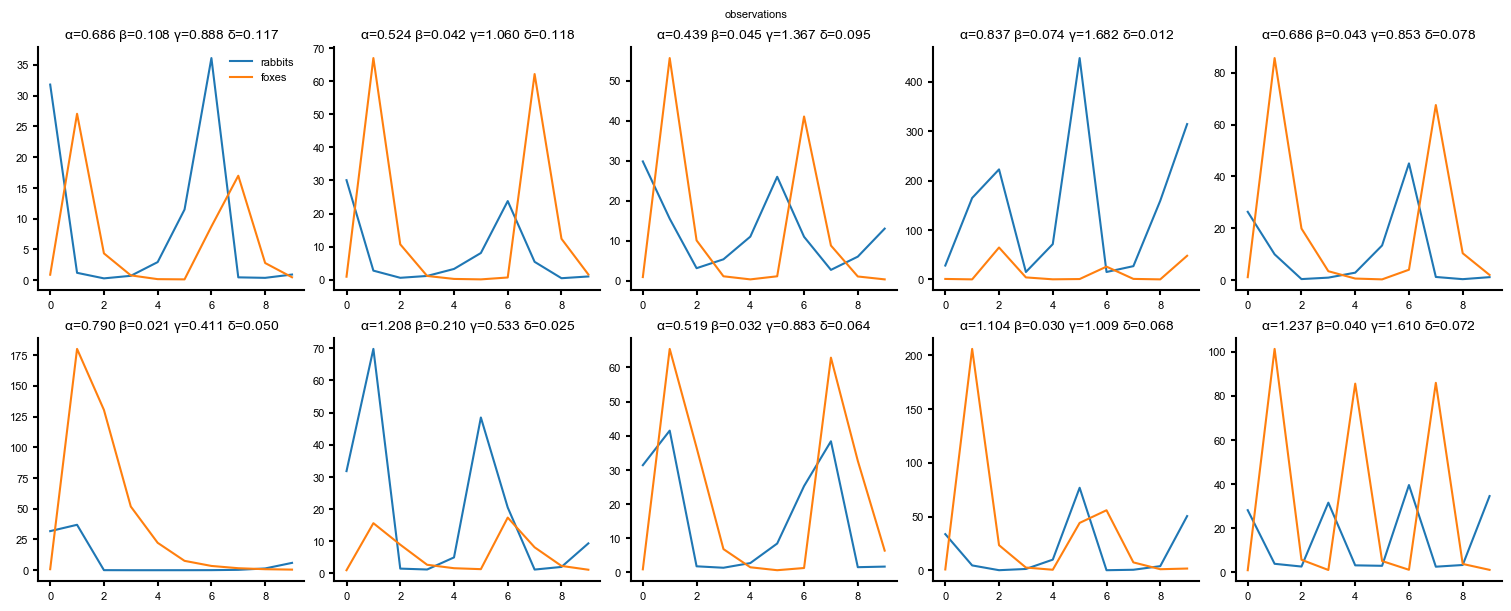

In [7]:
with mpl.rc_context(fname=plot_config_file):
    fig, axes = lv.plot_observations(2,5)
    plt.show()  

Prior

In [8]:
lv.prior_params

{'loc': tensor([-0.1250, -3.0000, -0.1250, -3.0000]),
 'scale': tensor([0.5000, 0.5000, 0.5000, 0.5000])}

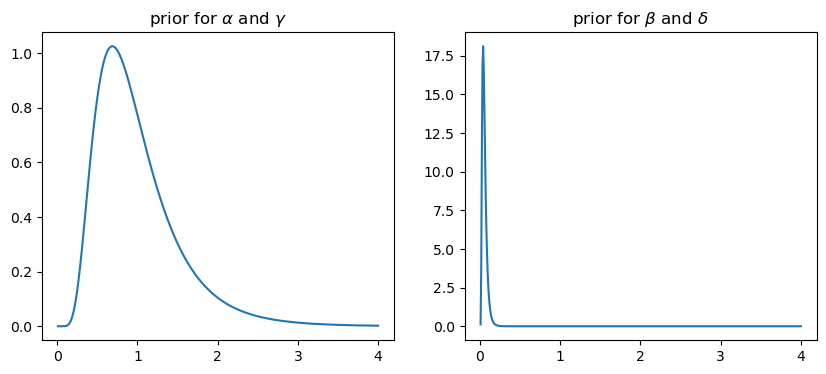

In [9]:
# priors defined as Log Normal with 
mu_p1 = -0.125
mu_p2 = -3.0
sigma_p = 0.5

ths  = torch.linspace(0,4, 500)
log_normal1 = torch.distributions.LogNormal(mu_p1, sigma_p)
log_normal2 = torch.distributions.LogNormal(mu_p2, sigma_p)

fig, axes = plt.subplots(1,2,figsize=(10,4))
axes[0].plot(ths, torch.exp(log_normal1.log_prob(ths)))
axes[0].set_title(r'prior for $\alpha$ and $\gamma$')
axes[1].plot(ths, torch.exp(log_normal2.log_prob(ths)))
axes[1].set_title(r'prior for $\beta$ and $\delta$')
plt.show()

Posterior

Only 10 reference samples given

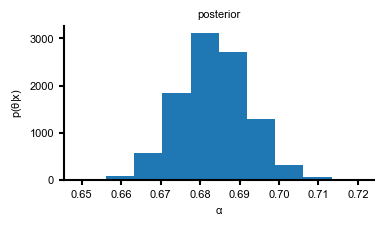

In [10]:
param = 0
n_obs = 1
posterior_evals = lv.get_reference_samples(n_obs)[:, param]
with mpl.rc_context(fname=plot_config_file):
    fig, ax = plt.subplots(1, 1, figsize=(4, 2))
    ax.hist(posterior_evals)
    ax.set_xlabel(rf"{lv.parameter_names[param]}")
    ax.set_ylabel(r"$p(\theta|x)$")
    ax.set_title("posterior")
    plt.show()

## Binary Actions

### Decision Task with $T_\alpha=0.675$

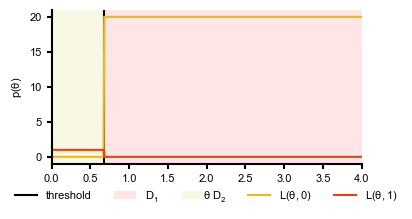

In [11]:
lower = 0
upper = 4
threshold = 0.675
costs = [20.0, 1.0]
cost_fn = StepCost_weighted(costs, threshold=threshold)
plot_step_loss(cost_fn, lower, upper, threshold, resolution=500, plot_config_file=plot_config_file)

### Load data

In [15]:
n_train = 50_000
n_test = 5_000
n_actions = 2

theta_train, x_train, theta_val, x_val, theta_test, x_test = load_data(lv.task_name)
theta_train = theta_train[: n_train, param: param+1]
x_train = x_train[: n_train]
theta_val = theta_val[: n_test, param: param+1]
x_val = x_val[: n_test]
theta_test = theta_test[: n_test, param: param+1 ]
x_test = x_test[: n_test]

print(f"theta_train = {theta_train.shape}, N_val = {theta_val.shape[0]}, N_test = {theta_test.shape[0]}")

Load data from './data/lotka_volterra', device = cpu.
theta_train = torch.Size([50000, 1]), N_val = 5000, N_test = 5000


### Train a neural network to predict expected costs

In [17]:
nn = build_nn(
    model="fc",
    x_train=x_train,
    action_train=lv.actions.sample(x_train.shape[0]),
    hidden_dims=[50, 50, 50],
    output_dim=1,
    activation=torch.nn.ReLU(),
    output_transform=torch.nn.ReLU(),
)
print(nn, end="\n-----\n")

nn, train_loss, val_loss = train(
    model=nn,
    x_train=x_train,
    theta_train=theta_train,
    cost_fn=cost_fn,
    x_val=x_val,
    theta_val=theta_val,
    actions=lv.actions,
    learning_rate=1e-3,
    model_dir=f"./results/{lv.task_name}/binary/notebook",
    stop_after_epochs=40,
)

FeedforwardNN(
  (standardize_layer): Standardize()
  (input_layer): Linear(in_features=21, out_features=50, bias=True)
  (hidden_layers): ModuleList(
    (0-1): 2 x Linear(in_features=50, out_features=50, bias=True)
  )
  (final_layer): Linear(in_features=50, out_features=1, bias=True)
  (activation): ReLU()
  (output_transform): ReLU()
)
-----
Subdirectory 'checkpoints' already exists. Delete first if wanted.
Converged after 345 epochs. train_loss = 4.88741137	 last_improvement = 25


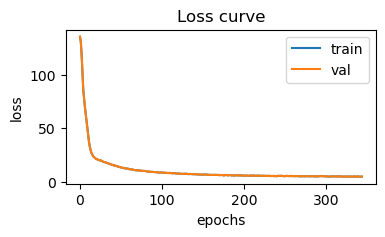

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(4, 2))
ax.plot(train_loss, label="train")
ax.plot(train_loss, label="val")
ax.set_title("Loss curve")
ax.set_xlabel("epochs")
ax.set_ylabel("loss")
ax.legend()
plt.show()

### Evaluate model

In [19]:
x_reference = torch.vstack([lv.get_observation(i) for i in range(1, 11)])
post_reference = torch.stack([lv.get_reference_samples(i) for i in range(1, 11)])[:, :, param]
param_reference = torch.vstack([lv.get_true_parameters(i) for i in range(1, 11)])[:, param]
actions_evaluate = lv.actions.sample(x_train.shape[0])


Check predictions on the reference observations

In [54]:
a = 1
predicted_expected_costs = nn(x_reference, a * torch.ones((x_reference.shape[0], 1)))
# true_expected_costs = torch.Tensor([(cost_fn(true_theta=post_reference[i], action=a)).mean() for i in range(0,10)])
true_expected_costs = torch.vstack(
    [lv.expected_posterior_costs(x=i, a=torch.Tensor([0, 1]), param=param, cost_fn=cost_fn) for i in range(1, 11)]
)

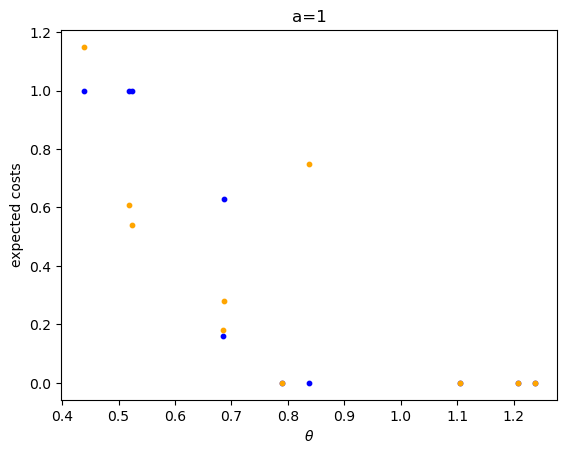

In [55]:
with torch.no_grad():
    cond = actions_evaluate == a
    plt.scatter(param_reference, true_expected_costs[:, a], s=10, c="blue")
    plt.scatter(param_reference, predicted_expected_costs, s=10, c="orange")
    plt.title(f"a={a}")
    plt.xlabel(r"$\theta$")
    plt.ylabel("expected costs")
    plt.show()

In [60]:
# MSE
print(f"MSE for expected costs given a={a}: {((predicted_expected_costs - true_expected_costs[:,a])**2).mean():.6f}")

MSE for expected costs given a=1: 0.341603


Check posterior ratios on test data

In [61]:
preds_0 = nn(x_reference, torch.zeros((x_reference.shape[0], 1)))
preds_1 = nn(x_reference, torch.ones((x_reference.shape[0], 1)))
# clip predictions to 0, if lower
preds_0[preds_0 < 0] = 0
preds_1[preds_1 < 0] = 0

ratios_nn = preds_0 / (preds_0 + preds_1)

ratios_posterior_samples = torch.hstack([lv.posterior_ratio_binary(i, param, cost_fn) for i in range(1, 11)])

AttributeError: 'LotkaVolterra' object has no attribute 'posterior_ratio_binary'

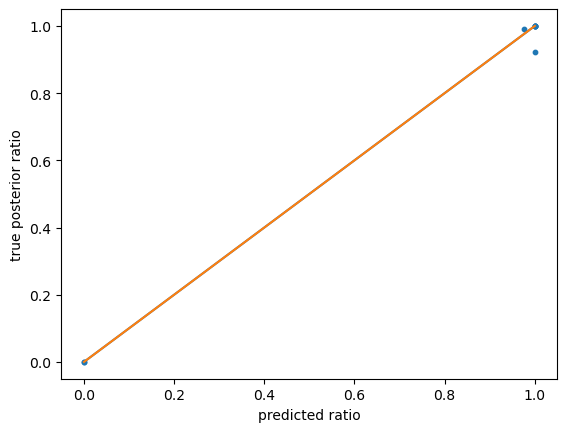

In [ ]:
plt.plot([(0, 0), (1, 1)])
plt.scatter(ratios_nn.detach().numpy(), ratios_posterior_samples.numpy(), s=10)
plt.xlabel("predicted ratio")
plt.ylabel("true posterior ratio")
# plt.savefig("results/lotka_volterra/fig_....png")
plt.show()